In [1]:
import numpy as np
from tqdm import tqdm
import pymc as pm
import skfem as fem
from skfem import MeshLine, ElementLineP1, Basis, BilinearForm, LinearForm
from skfem.helpers import dot, grad, d, dd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import truncnorm
import scipy.stats as scstats
import scipy.sparse as scsparse
import scipy.optimize as scoptimize
import scipy.linalg as sclinalg

import pytensor.tensor.subtensor as subtensor
import pytensor.tensor as tensor
import pytensor.sparse as sparsetensor
import arviz as az

In [2]:
import scienceplots
# plot params
contour_levels = 20
plt.style.use(['science', 'grid'])
color_list = [(253, 231, 37),(194, 223, 35),(134, 213, 73),(82, 197, 105),(42, 176, 127),(30, 155, 138),(37, 133, 142),(45, 112, 142),(56, 88, 140),(67, 62, 133),(72, 33, 115),(68, 1, 84)]
color_list = [tuple(ti/255 for ti in t) for t in color_list]

In [3]:
#number_of_x_axial_cells = 200
number_of_x_axial_cells = 200

# x_axis_left_boundary = 0.
# x_axis_right_boundary = 1.

x_axis_left_boundary = -6.
x_axis_right_boundary = 6.

x_s = np.linspace(x_axis_left_boundary, x_axis_right_boundary, number_of_x_axial_cells)

t_start = 0
dt = 0.02
t_end = 4.
time_range = np.arange(t_start, t_end, dt)
number_of_steps = len(time_range)

true_nu = 0.01

mesh = fem.MeshLine(x_s)
element = fem.ElementLineP1()
basis = fem.Basis(mesh, element)

newton_tol = 0.00001

true_coordinates = mesh.p.T
n_x = len(true_coordinates)
boundary_condition = (
    (true_coordinates == x_axis_left_boundary) | (true_coordinates == x_axis_right_boundary)
)
boundary_indices = np.where(boundary_condition)[0]

#u_0 = np.sin(2*np.pi*true_coordinates).flatten()
#u_0 = np.exp((-(true_coordinates.flatten())**2)/2)
u_0true = np.exp(-((true_coordinates.flatten()-1)**2)/2) - np.exp(-((true_coordinates.flatten()+1)**2)/2) 
u_strue = np.zeros((number_of_steps, n_x))
u_strue[0,:] = u_0true

u_guess = u_0true + np.random.normal(0, 0.001, len(u_0true))
u_guess[0] = u_guess[-1] = 0

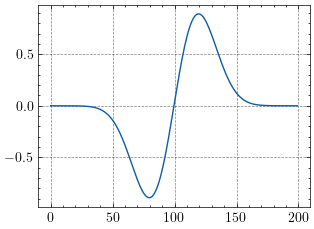

In [4]:
plt.plot(u_0true)

In [5]:
# Observation Parameters
sigma_n_true = 0.05
spatial_points = 8
temporal_points = 10

temp = np.linspace(0, len(true_coordinates) - 1, spatial_points+2, dtype=int)
spatial_measurement_indices = temp[1:-1]
spatial_measurement_coordinates = true_coordinates[spatial_measurement_indices]
temp = np.linspace(0, len(time_range) - 1, temporal_points+2, dtype=int)
temporal_measurement_indices = temp[1:-1]
temporal_measurement_coordinates = time_range[temporal_measurement_indices]

In [6]:
import sympy as sp

# Define the symbols and functions
x = sp.symbols('x')  # Spatial variable
u, u_0, v, u_hat = sp.symbols(r'u u_0 v \hat{u}', cls=sp.Function)  # Functions
Delta_t, nu, epsilon = sp.symbols('Delta_t nu epsilon')  # Constants

# Define the derivatives
u_prime = sp.diff(u(x), x)
u_0prime = sp.diff(u_0(x),x)
v_prime = sp.diff(v(x), x)

# Define the functional F
#F = (u(x) + Delta_t * u(x) * u_prime - u_0(x)) * v(x) + Delta_t * nu * u_prime * v_prime
F = (u(x)*(1+(Delta_t/2)*u_prime))*v(x) + (Delta_t * nu / 2)*(u_prime*v_prime) - (u_0(x)*(1-(Delta_t/2)*u_0prime))*v(x) + (Delta_t*nu/2)*(u_0prime*v_prime)

# Define the perturbed functional F(u + epsilon * u_hat)
u_perturbed = u(x) + epsilon * u_hat(x)
u_perturbed_prime = sp.diff(u_perturbed, x)
#F_perturbed = (u_perturbed + Delta_t * u_perturbed * u_perturbed_prime - u_0(x)) * v(x) + Delta_t * nu * u_perturbed_prime * v_prime
F_perturbed = (u_perturbed*(1+(Delta_t/2)*u_perturbed_prime))*v(x) + (Delta_t * nu / 2)*(u_perturbed_prime*v_prime) - (u_0(x)*(1-(Delta_t/2)*u_0prime))*v(x) + (Delta_t*nu/2)*(u_0prime*v_prime)

# Compute the Gâteaux derivative (directional derivative)
Gateaux_derivative = sp.limit((F_perturbed - F) / epsilon, epsilon, 0)

# Display the result
Gateaux_derivative_simplified = sp.simplify(Gateaux_derivative)
Gateaux_derivative_simplified


Delta_t*nu*Derivative(\hat{u}(x), x)*Derivative(v(x), x)/2 + Delta_t*\hat{u}(x)*v(x)*Derivative(u(x), x)/2 + Delta_t*u(x)*v(x)*Derivative(\hat{u}(x), x)/2 + \hat{u}(x)*v(x)

In [7]:
# EXPLICIT EULER

@fem.LinearForm
def F_functional(v,w):
    return (w.u_k + dt*w.u_k*grad(w.u_k)[0]-w.u_0)*v + dt*true_nu*dot(grad(w.u_k),grad(v))

@fem.BilinearForm
def F_jacobian(u,v,w):
    return u*v + dt*w.u_k*grad(u)[0]*v + dt*grad(w.u_k)[0]*u*v + dt*true_nu*dot(grad(u),grad(v))

# CRANK NICHOLSON

@fem.LinearForm
def F_functional(v,w):
    return w.u_k*(1+(dt/2)*grad(w.u_k)[0])*v + (dt*true_nu/2)*dot(grad(w.u_k), grad(v)) - w.u_0*(1-(dt/2)*grad(w.u_0)[0])*v + (dt*true_nu/2)*dot(grad(w.u_0), grad(v))

@fem.BilinearForm
def F_jacobian(u,v,w):
    return u*v + (dt*true_nu/2)*dot(grad(u),grad(v)) + (dt/2)*u*grad(w.u_k)[0]*v + (dt/2)*grad(u)[0]*w.u_k*v

In [8]:
for i in tqdm(range(number_of_steps-1)):
    du_norm = 1.
    while du_norm > newton_tol:
        # calculate the residual, with the next u_k being our guess, and u_0 being the previous point
        u_k_resid = F_functional.assemble(basis, u_k = basis.interpolate(u_guess), u_0 = basis.interpolate(u_strue[i,:]))
        # set boundary conditions
        u_k_resid[0] = u_k_resid[-1] = 0.
        j_mat = F_jacobian.assemble(basis, u_k = basis.interpolate(u_guess), u_0 = basis.interpolate(u_strue[i,:]))
        j_mat[0,:] = j_mat[-1,:] = 0.
        j_mat[0,0] = j_mat[-1,-1] = 1.
        du_norm = np.linalg.norm(u_k_resid)
        u_guess = u_guess + scsparse.linalg.spsolve(j_mat, -u_k_resid)
    u_strue[i+1,:] = u_guess


  0%|          | 0/199 [00:00<?, ?it/s]/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
100%|██████████| 199/199 [00:01<00:00, 155.06it/s]


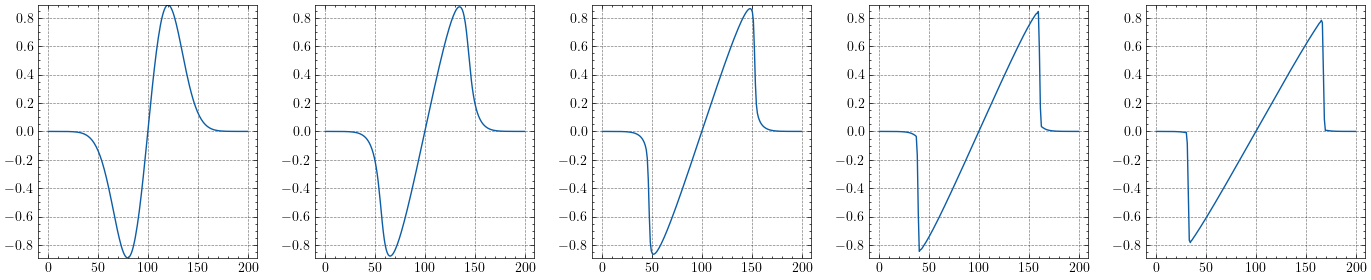

In [9]:
u_observed = u_strue[temporal_measurement_indices][:, spatial_measurement_indices] + np.random.normal(0, sigma_n_true, (temporal_points, spatial_points))

fig, axes = plt.subplots(1, 5, figsize=(14,3))
ymin = np.min(u_strue[1])
ymax = np.max(u_strue[1])
axes[0].plot(u_strue[1])
axes[0].set_ylim(ymin, ymax)
axes[1].plot(u_strue[51])
axes[1].set_ylim(ymin, ymax)
axes[2].plot(u_strue[101])
axes[2].set_ylim(ymin, ymax)
axes[3].plot(u_strue[151])
axes[3].set_ylim(ymin, ymax)
axes[4].plot(u_strue[199])
axes[4].set_ylim(ymin, ymax)
fig.tight_layout()
plt.show()

In [10]:
for i in tqdm(range(number_of_steps-1)):
    def residual(u_guess):
        vec = F_functional.assemble(basis, u_k = basis.interpolate(u_guess), u_0 = basis.interpolate(u_strue[i,:]))
        vec[0] = vec[-1] = 0
        return vec
    u_next = scoptimize.root(residual, u_strue[i,:], method='krylov').x
    u_strue[i+1,:] = u_next

100%|██████████| 199/199 [00:02<00:00, 84.97it/s] 


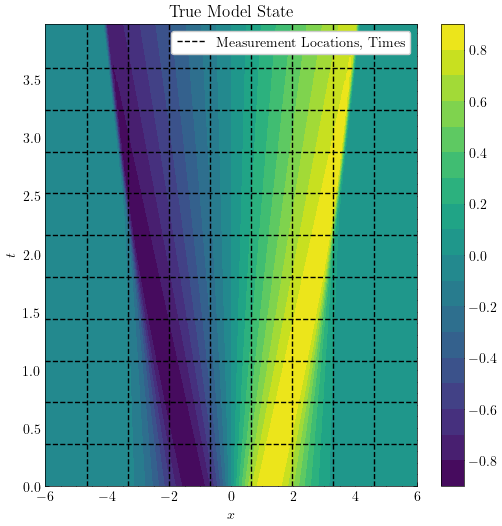

In [10]:
fig, axes = plt.subplots(figsize=(6,6))
plot = axes.contourf(true_coordinates.flatten(), time_range, u_strue, levels=contour_levels)
num = 0
for coord in spatial_measurement_coordinates.flatten():
    if num == 0:
        axes.axvline(coord, linestyle='--', label='Measurement Locations, Times', color='black')
    else:
        axes.axvline(coord, linestyle='--', color='black')
    num += 1
num = 0
for coord in temporal_measurement_coordinates.flatten():
    if num == 0:
        axes.axhline(coord, linestyle='--', color='black')
    else:
        axes.axhline(coord, linestyle='--', color='black')
    num += 1

x_temp, y_temp = np.meshgrid(true_coordinates[spatial_measurement_indices].flatten(), time_range[temporal_measurement_indices].flatten())
x_temp, y_temp = x_temp.flatten(), y_temp.flatten()

#axes.scatter(x_temp, y_temp, marker='x', label='Observed Points', color='black')
axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$t$')
axes.set_title('True Model State')
fig.colorbar(plot)
plt.legend()
plt.show()

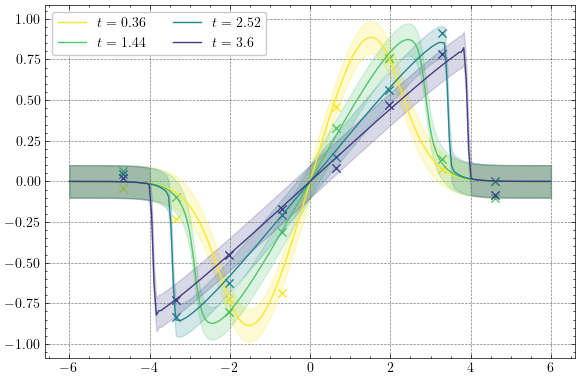

In [11]:
time_labels = [r"$t=$ "+str(round(temporal_measurement_coordinates[i],3)) for i in range(len(temporal_measurement_coordinates))]
mes_ind = 5
fig, axes = plt.subplots(figsize=(6,4))
for mes_ind in range(0, temporal_points, 3):
    axes.plot(true_coordinates, u_strue[temporal_measurement_indices[mes_ind],:], color=color_list[mes_ind], label=time_labels[mes_ind])
    axes.scatter(spatial_measurement_coordinates, u_observed[mes_ind,:], color=color_list[mes_ind], marker='x')
    axes.fill_between(true_coordinates.flatten(), u_strue[temporal_measurement_indices[mes_ind],:] - 2*sigma_n_true,u_strue[temporal_measurement_indices[mes_ind],:] + 2*sigma_n_true, alpha=0.2, color=color_list[mes_ind])

axes.legend(ncols=2)
fig.tight_layout()
plt.show()

In [12]:
#number_of_x_axial_cells = 200
number_of_x_axial_cells = 200

# x_axis_left_boundary = 0.
# x_axis_right_boundary = 1.

x_axis_left_boundary = -6.
x_axis_right_boundary = 6.

x_s = np.linspace(x_axis_left_boundary, x_axis_right_boundary, number_of_x_axial_cells)

t_start = 0
dt = 0.02
t_end = 4.
time_range = np.arange(t_start, t_end, dt)
number_of_steps = len(time_range)

mesh = fem.MeshLine(x_s)
element = fem.ElementLineP1()
basis = fem.Basis(mesh, element)

newton_tol = 0.00001

coordinates = mesh.p.T
n_x = len(coordinates)
boundary_condition = (
    (coordinates == x_axis_left_boundary) | (coordinates == x_axis_right_boundary)
)
boundary_indices = np.where(boundary_condition)[0]

#u_0 = np.sin(2*np.pi*coordinates).flatten()
#u_0 = np.exp((-(coordinates.flatten())**2)/2)
u_0 = np.exp(-((coordinates.flatten()-1)**2)/2) - np.exp(-((coordinates.flatten()+1)**2)/2) 
u_s = np.zeros((number_of_steps, n_x))
u_s[0,:] = u_0

u_guess = u_0 + np.random.normal(0, 0.001, len(u_0))
u_guess[0] = u_guess[-1] = 0

covs = [np.zeros((n_x, n_x))]

observation_operator = np.zeros((len(spatial_measurement_coordinates), len(coordinates)))
for i, y in enumerate(spatial_measurement_coordinates):
    nearest_index = np.argmin(np.abs(coordinates - y))
    observation_operator[i, nearest_index] = 1

def mark_times(all_time, mark_time):
    time_operator = np.zeros_like(all_time, dtype=bool)

    # Find the closest point in X for each element in Y
    for time in mark_time:
        closest_index = np.argmin(np.abs(all_time - time))
        time_operator[closest_index] = True
    return time_operator

time_operator = mark_times(time_range, temporal_measurement_coordinates)

In [13]:
K_theta_1 = np.tile(coordinates, ((n_x, 1)))
K_theta_2 = np.repeat(coordinates, (n_x), axis=0)
K_theta_3 = -np.linalg.norm(K_theta_1 - K_theta_2,axis=1)
K_theta_3_np = -np.linalg.norm(K_theta_1 - K_theta_2,axis=1)

# CRANK NICHOLSON

@fem.BilinearForm
def M_matrix(u,v,w):
    return u*v
M_mat = M_matrix.assemble(basis).toarray()

@fem.LinearForm
def F1_functional(v,w):
    return w.u_k*(1+(dt/2)*grad(w.u_k)[0])*v - w.u_0*(1-(dt/2)*grad(w.u_0)[0])*v 
    # + (dt*true_nu/2)*dot(grad(w.u_k), grad(v)) 
    # + (dt*true_nu/2)*dot(grad(w.u_0), grad(v))

@fem.LinearForm
def F2_functional(v,w):
    return (dt/2)*dot(grad(w.u_k), grad(v)) 

@fem.LinearForm
def F3_functional(v,w):
    return (dt/2)*dot(grad(w.u_0), grad(v)) 

def F_assemble(nu, u_k, u_0):
    F1 = F1_functional.assemble(basis, u_k = u_k, u_0 = u_0)
    F2 = nu*F2_functional.assemble(basis, u_k = u_k)
    F3 = nu*F3_functional.assemble(basis, u_0 = u_0)
    F = F1 + F2 + F3
    F = subtensor.set_subtensor(F[0], 0.)
    F = subtensor.set_subtensor(F[-1], 0.)
    return F

def F_assemble_np(nu, u_k, u_0):
    F1 = F1_functional.assemble(basis, u_k = u_k, u_0 = u_0)
    F2 = nu*F2_functional.assemble(basis, u_k = u_k)
    F3 = nu*F3_functional.assemble(basis, u_0 = u_0)
    F = F1 + F2 + F3
    F[0] = F[-1] = 0.
    return F

# @fem.BilinearForm
# def F_jacobian(u,v,w):
#     u*v 
#     + (dt*true_nu/2)*dot(grad(u),grad(v)) 
#     + (dt/2)*u*grad(w.u_k)[0]*v 
#     + (dt/2)*grad(u)[0]*w.u_k*v

@fem.BilinearForm
def J1_jacobian(u,v,w):
    return u*v + (dt/2)*u*grad(w.u_k)[0]*v + (dt/2)*grad(u)[0]*w.u_k*v

@fem.BilinearForm
def J2_jacobian(u,v,w):
    return (dt/2)*dot(grad(u),grad(v))

def J_assemble(nu, u_k):
    J1 = J1_jacobian.assemble(basis, u_k = u_k).toarray()
    J2 = nu * J2_jacobian.assemble(basis).toarray()
    J = J1 + J2
    J = subtensor.set_subtensor(J[0,:], 0.)
    J = subtensor.set_subtensor(J[-1,:], 0.)
    J = subtensor.set_subtensor(J[0,0], 1.)
    J = subtensor.set_subtensor(J[-1,-1], 1.)
    return J
    
def J_assemble_np(nu, u_k):
    J1 = J1_jacobian.assemble(basis, u_k = u_k)
    J2 = nu*J2_jacobian.assemble(basis)
    J = J1 + J2
    J[0,:] = J[-1,:] = 0.
    J[0,0] = J[-1,-1] = 1.
    return J

def G_theta_mat(rho, ell):
    G_vec = (rho**2)*tensor.math.exp(K_theta_3/(2*(ell**2)))
    #return M_mat @ tensor.reshape(G_vec, (n_x, n_x)) @ M_mat.T
    return tensor.reshape(G_vec, (n_x, n_x))

def G_theta_mat_np(rho, ell):
    G_vec = (rho**2)*np.exp(K_theta_3_np/(2*(ell**2)))
    return np.reshape(G_vec, (n_x, n_x))

In [14]:
# PRIORS ------------
# nu
lower = 0.0001
upper = 3.
mu = 0.01
sigma = 0.01
nu_params = [lower, upper, mu, sigma]

# rho
lower = 0.0001
upper = 1.
mu = 0.05
sigma = 0.05
rho_params = [lower, upper, mu, sigma]

# ell
lower = 0.0001
upper = 3.
mu = 1
sigma = 0.5
ell_params = [lower, upper, mu, sigma]

# sigma_n
lower = 0.0001
upper = 1.
mu = 0.05
sigma = 0.05
sigma_n_params = [lower, upper, mu, sigma]

# --------------

In [15]:
nu = nu_params[2]
rho = rho_params[2]
ell = ell_params[2]
sigma_n = sigma_n_params[2]

traces = [] # box of traces
jacobs = []
inv_jacobs = []

data_index = 0

for i, t in tqdm(enumerate(time_range[:-1])):
    if time_operator[i] == False: # if we do not have data
    #if True == True:
        du_norm = 1.
        while du_norm > newton_tol:
            # calculate the residual, with the next u_k being our guess, and u_0 being the previous point
            pred_mean_resid = F_assemble_np(nu, u_k = basis.interpolate(u_guess), u_0 = basis.interpolate(u_s[i,:]))
            j_mat = J_assemble_np(nu, u_k = basis.interpolate(u_guess))
            du_norm = np.linalg.norm(u_k_resid)
            u_guess = u_guess + scsparse.linalg.spsolve(j_mat, -pred_mean_resid)
        pred_mean = u_guess
        j_mat = j_mat.toarray()
        jacobs.append(j_mat)
        inv_jacobs.append(np.linalg.inv(j_mat))
        if i==0:
            pred_cov = dt * inv_jacobs[-1] @ M_mat @ G_theta_mat_np(rho, ell) @ M_mat.T @ inv_jacobs[-1].T
            covs.append(pred_cov)
        else:
            C1 = inv_jacobs[-1] @ (jacobs[-2] @ covs[-1] @ jacobs[-2].T) @ inv_jacobs[-1].T
            C2 = dt * inv_jacobs[-1] @ M_mat @ G_theta_mat_np(rho, ell) @ M_mat.T @ inv_jacobs[-1].T
            pred_cov = C1 + C2
            covs.append(pred_cov)
        u_s[i+1, :] = pred_mean
        
    # else: # if we do have data
    #     du_norm = 1.
    #     while du_norm > newton_tol:
    #         # calculate the residual, with the next u_k being our guess, and u_0 being the previous point
    #         pred_mean_resid = F_assemble_np(nu, u_k = basis.interpolate(u_guess), u_0 = basis.interpolate(u_s[i,:]))
    #         j_mat = J_assemble_np(nu, u_k = basis.interpolate(u_guess))
    #         du_norm = np.linalg.norm(u_k_resid)
    #         u_guess = u_guess + scsparse.linalg.spsolve(j_mat, -pred_mean_resid)
    #     pred_mean = u_guess
    #     j_mat = j_mat.toarray()
    #     jacobs.append(j_mat)
    #     inv_jacobs.append(np.linalg.inv(j_mat))
    #     if i==0:
    #         pred_cov = dt * inv_jacobs[-1] @ G_theta_mat_np(rho, ell) @ inv_jacobs[-1].T
    #     else:
    #         C1 = inv_jacobs[-1] @ (jacobs[-2] @ covs[-1] @ jacobs[-2].T) @ inv_jacobs[-1].T
    #         C2 = dt * inv_jacobs[-1] @ G_theta_mat_np(rho, ell) @ inv_jacobs[-1].T
    #         pred_cov = C1 + C2
    #     S_n = observation_operator @ pred_cov @ observation_operator.T + (sigma_n**2) * np.eye(spatial_points)
    #     updated_mean = pred_mean + pred_cov @ observation_operator.T @ np.linalg.inv(S_n) @ (u_observed[data_index,:] - observation_operator @ pred_mean)
    #     updated_cov = pred_cov - pred_cov @ observation_operator.T @ np.linalg.inv(S_n) @ observation_operator @ pred_cov
    #     covs.append(updated_cov)
    #     u_s[i+1, :] = updated_mean
    #     data_index += 1

    else: # if we do have data
        with pm.Model() as model:
            if data_index == 0:
                nu = pm.TruncatedNormal('nu', mu=nu_params[3], sigma=nu_params[2], lower=nu_params[0], upper=nu_params[1])
                rho = pm.TruncatedNormal('rho', mu=rho_params[3], sigma=rho_params[2], lower=rho_params[0], upper=rho_params[1])
                ell = pm.TruncatedNormal('ell', mu=ell_params[3], sigma=ell_params[2], lower=ell_params[0], upper=ell_params[1])
                sigma_n = pm.TruncatedNormal('sigma_n', mu=sigma_n_params[3], sigma=sigma_n_params[2], lower=sigma_n_params[0], upper=sigma_n_params[1])
            else:
                nu = pm.TruncatedNormal('nu', mu=nu, sigma=nu_std, lower=nu_updated_params[0], upper=nu_updated_params[1])
                rho = pm.TruncatedNormal('rho', mu=rho, sigma=rho_std, lower=rho_updated_params[0], upper=rho_updated_params[1])
                ell = pm.TruncatedNormal('ell', mu=ell, sigma=ell_std, lower=ell_updated_params[0], upper=ell_updated_params[1])
                sigma_n = pm.TruncatedNormal('sigma_n', mu=sigma_n, sigma=sigma_n_std, lower=sigma_n_updated_params[0], upper=sigma_n_updated_params[1])

            u_0_test = basis.interpolate(u_s[i,:])

            du_norm = 1.
            while du_norm > newton_tol:
                # calculate the residual, with the next u_k being our guess, and u_0 being the previous point
                u_k_test = basis.interpolate(u_guess)

                pred_mean_resid = F_assemble(nu, u_k=u_k_test, u_0 = u_0_test)

                j_mat = J_assemble(nu, u_k = u_k_test)

                du_norm = tensor.nlinalg.norm(u_k_resid).eval()
                u_guess = u_guess + tensor.nlinalg.tensorsolve(j_mat, -pred_mean_resid).eval()
            
            mu_u = pm.Deterministic('mu_u', tensor.as_tensor(observation_operator @ u_guess))

            inv_j_mat = tensor.nlinalg.inv(j_mat)

            j_mat_prev = J_assemble(nu, u_k = u_s[i,:])

            cov_1 = pm.Deterministic('cov_1', inv_j_mat @ j_mat_prev @ covs[-1] @ j_mat_prev.T @ inv_j_mat.T)
            cov_2 = pm.Deterministic('cov_2', inv_j_mat @ M_mat @ G_theta_mat(rho, ell) @ M_mat.T @ inv_j_mat.T)

            cov_u = pm.Deterministic('cov_u', observation_operator @ cov_1 @ observation_operator.T + dt * observation_operator @ cov_2 @ observation_operator.T + (sigma_n**2)*np.eye(spatial_points))
            cov_chol = pm.Deterministic('cov_chol', tensor.linalg.cholesky(cov_u))

            y_obs = pm.MvNormal('y_obs', mu = mu_u, chol = cov_chol, observed = u_observed[data_index,:])

            trace = pm.sample(nuts_sampler="numpyro", chains=2, target_accept=0.95)
            #trace = pm.sample()
            traces.append(trace)

        # update parameters to means of their posteriors
        nu = np.mean(traces[-1].posterior['nu'].data.flatten())
        nu_std = np.std(traces[-1].posterior['nu'].data.flatten())
        nu_updated_params = [nu - 2*nu_std, nu + 2*nu_std, nu, nu_std]

        rho = np.mean(traces[-1].posterior['rho'].data.flatten())
        rho_std = np.std(traces[-1].posterior['rho'].data.flatten())
        rho_updated_params = [rho - 2*rho_std, rho + 2*rho_std, rho, rho_std]

        ell = np.mean(traces[-1].posterior['ell'].data.flatten())
        ell_std = np.std(traces[-1].posterior['ell'].data.flatten())
        ell_updated_params = [ell - 2*ell_std, ell + 2*ell_std, ell, ell_std]

        sigma_n = np.mean(traces[-1].posterior['sigma_n'].data.flatten())
        sigma_n_std = np.std(traces[-1].posterior['sigma_n'].data.flatten())
        sigma_n_updated_params = [sigma_n- 2*sigma_n_std, sigma_n + 2*sigma_n_std, sigma_n, sigma_n_std]

        du_norm = 1.
        while du_norm > newton_tol:
            # calculate the residual, with the next u_k being our guess, and u_0 being the previous point
            pred_mean_resid = F_assemble_np(nu, u_k = basis.interpolate(u_guess), u_0 = basis.interpolate(u_s[i,:]))
            j_mat = J_assemble_np(nu, u_k = basis.interpolate(u_guess))
            du_norm = np.linalg.norm(u_k_resid)
            u_guess = u_guess + scsparse.linalg.spsolve(j_mat, -pred_mean_resid)
        pred_mean = u_guess
        j_mat_prev = J_assemble_np(nu, u_k = basis.interpolate(u_s[i,:]))
        j_mat = j_mat.toarray()
        jacobs.append(j_mat)
        inv_jacobs.append(np.linalg.inv(j_mat))
        if i==0:
            pred_cov = dt * inv_jacobs[-1] @ G_theta_mat_np(rho, ell) @ inv_jacobs[-1].T
        else:
            C1 = inv_jacobs[-1] @ (j_mat_prev @ covs[-1] @ j_mat_prev.T) @ inv_jacobs[-1].T
            C2 = dt * inv_jacobs[-1] @ G_theta_mat_np(rho, ell) @ inv_jacobs[-1].T
            pred_cov = C1 + C2
        S_n = observation_operator @ pred_cov @ observation_operator.T + (sigma_n**2) * np.eye(spatial_points)
        updated_mean = pred_mean + pred_cov @ observation_operator.T @ np.linalg.inv(S_n) @ (u_observed[data_index,:] - observation_operator @ pred_mean)
        updated_cov = pred_cov - pred_cov @ observation_operator.T @ np.linalg.inv(S_n) @ observation_operator @ pred_cov
        covs.append(updated_cov)
        u_s[i+1, :] = updated_mean
        data_index += 1

16it [00:11, 38.64it/s]/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/jax/_src/linear_util.py:192: UserWarning: We will disable progress bar because it does not work yet on multi-GPUs platforms.
  ans = self.f(*args, **dict(self.params, **kwargs))
We recommend running at least 4 chains for robust computation of convergence diagnostics
/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
33it [03:21,  5.32s/it]/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/jax/_src/linear_util.py:192: UserWarning: We will disable progress bar because it does not work yet on multi-GPUs platforms.
  ans = self.f(*args, **dict(self.params, **kwargs))
We recommend running at least 4 chains for robust computation of convergence diagnostics
/home/daniel/anaconda3/envs/pymcenv/lib/python3

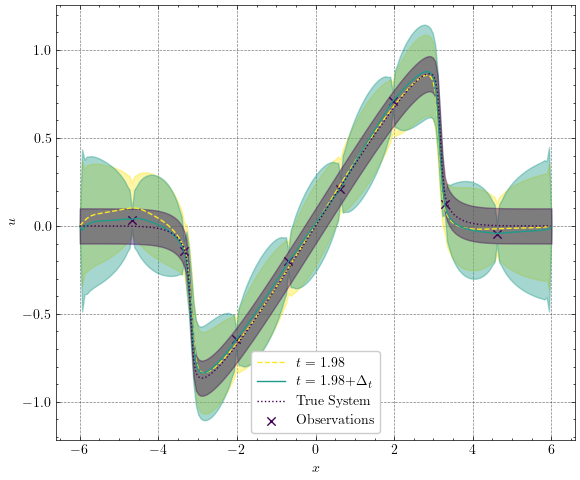

In [ ]:
cov_diags = np.zeros((number_of_steps, number_of_x_axial_cells))
for i in range(number_of_steps):
    cov_diags[i,:] = np.diag(covs[i])

interest = 1
time_labels = [r"$t=$ "+str(temporal_measurement_coordinates[i]) for i in range(len(temporal_measurement_coordinates))]
plot_ind = temporal_measurement_indices[interest]

fig, axes = plt.subplots(figsize=(6,5))

axes.plot(coordinates,u_s[plot_ind,:], label=time_labels[interest], color=color_list[0], linestyle='dashed')
axes.fill_between(coordinates.flatten(), u_s[plot_ind,:] - 2*np.sqrt(cov_diags[plot_ind]), u_s[plot_ind,:] + 2*np.sqrt(cov_diags[plot_ind]), alpha=0.4, color=color_list[0])

axes.plot(coordinates,u_s[plot_ind + 1,:], label=time_labels[interest] + r'$+ \Delta_t$', color=color_list[5])
axes.fill_between(coordinates.flatten(), u_s[plot_ind+1,:] - 2*np.sqrt(cov_diags[plot_ind+1]), u_s[plot_ind+1,:] + 2*np.sqrt(cov_diags[plot_ind+1]), alpha=0.4, color=color_list[5])

axes.plot(true_coordinates, u_strue[plot_ind+1,:], label='True System', color=color_list[11], linestyle='dotted')
axes.scatter(spatial_measurement_coordinates, u_observed[interest,:], label='Observations', marker='x', color=color_list[11])
axes.fill_between(true_coordinates.flatten(), u_strue[plot_ind+1,:] - 2*sigma_n_true*np.ones(len(true_coordinates)), u_strue[plot_ind+1,:] + 2*sigma_n_true*np.ones(len(true_coordinates)), alpha=0.4, color=color_list[11])

axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$u$')

axes.legend(loc='lower center')
fig.tight_layout()
plt.show()

In [ ]:
for time_index in tqdm(range(len(time_range))):
    filename = r"burger_pics/image" + str(time_index) + ".png"
    time_labels = [r"$t=$ "+str(time_range[i]) for i in range(len(time_range))]

    fig, axes = plt.subplots(figsize=(6,5))

    axes.plot(coordinates,u_s[time_index,:], label=time_labels[time_index], color=color_list[0])
    axes.fill_between(coordinates.flatten(), u_s[time_index,:] - 2*np.sqrt(cov_diags[time_index]), u_s[time_index,:] + 2*np.sqrt(cov_diags[time_index]), alpha=0.4, color=color_list[0])

    axes.plot(true_coordinates, u_strue[time_index,:], label='True System', color=color_list[11], linestyle='dotted')
    axes.fill_between(true_coordinates.flatten(), u_strue[time_index,:] - 2*sigma_n_true*np.ones(len(true_coordinates)), u_strue[time_index,:] + 2*sigma_n_true*np.ones(len(true_coordinates)), alpha=0.4, color=color_list[11])

    axes.set_xlabel(r'$x$')
    axes.set_ylabel(r'$u$')

    axes.set_ylim(-1.5, 1.5)

    axes.legend(loc='lower center')
    fig.tight_layout()
    plt.savefig(filename)
    plt.close()

100%|██████████| 200/200 [00:59<00:00,  3.36it/s]


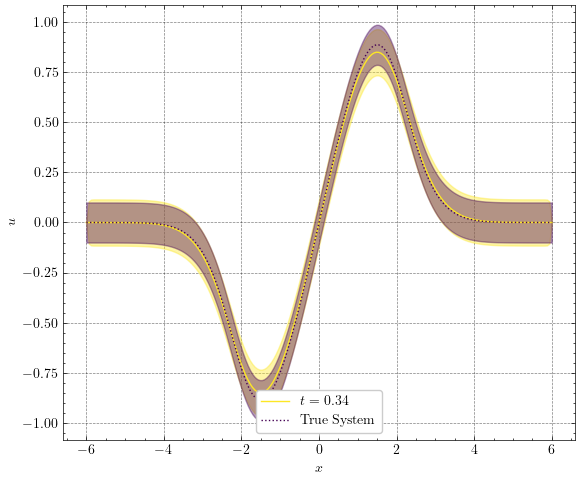

In [ ]:
cov_diags = np.zeros((number_of_steps, number_of_x_axial_cells))
for i in range(number_of_steps):
    cov_diags[i,:] = np.diag(covs[i])

time_index = 17
time_labels = [r"$t=$ "+str(time_range[i]) for i in range(len(time_range))]

fig, axes = plt.subplots(figsize=(6,5))

axes.plot(coordinates,u_s[time_index,:], label=time_labels[time_index], color=color_list[0])
axes.fill_between(coordinates.flatten(), u_s[time_index,:] - 2*np.sqrt(cov_diags[time_index]), u_s[time_index,:] + 2*np.sqrt(cov_diags[time_index]), alpha=0.4, color=color_list[0])

#axes.plot(true_coordinates, u_strue[time_index,:], label='True System', color=color_list[11], linestyle='dotted')
#axes.fill_between(true_coordinates.flatten(), u_strue[time_index,:] - 2*sigma_n_true*np.ones(len(true_coordinates)), u_strue[time_index,:] + 2*sigma_n_true*np.ones(len(true_coordinates)), alpha=0.4, color=color_list[11])

axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$u$')

axes.legend(loc='lower center')
fig.tight_layout()

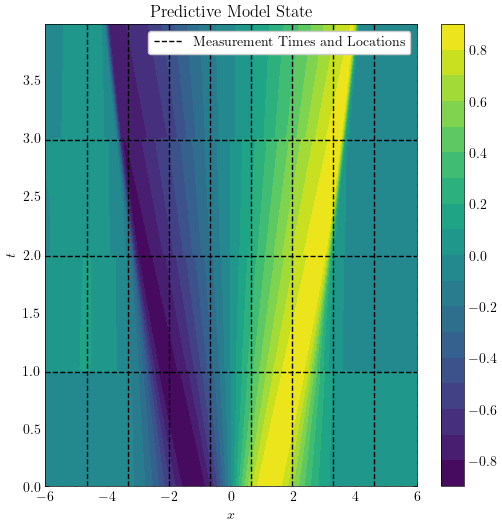

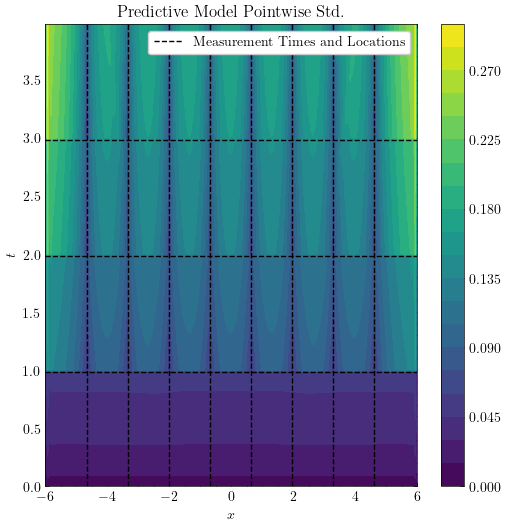

In [ ]:
fig, axes = plt.subplots(figsize=(6,6))
plot = axes.contourf(coordinates.flatten(), time_range, u_s, levels=contour_levels)
num = 0
for coord in spatial_measurement_coordinates.flatten():
    if num == 0:
        axes.axvline(coord, linestyle='--', label='Measurement Times and Locations', color='black')
    else:
        axes.axvline(coord, linestyle='--', color='black')
    num += 1
num = 0
for coord in temporal_measurement_coordinates.flatten():
    if num == 0:
        axes.axhline(coord, linestyle='--', color='black')
    else:
        axes.axhline(coord, linestyle='--', color='black')
    num += 1

x_temp, y_temp = np.meshgrid(true_coordinates[spatial_measurement_indices].flatten(), time_range[temporal_measurement_indices].flatten())
x_temp, y_temp = x_temp.flatten(), y_temp.flatten()

axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$t$')
axes.set_title('Predictive Model State')
fig.colorbar(plot)
plt.legend()
plt.show()

fig, axes = plt.subplots(figsize=(6,6))
plot = axes.contourf(coordinates.flatten(), time_range, np.sqrt(cov_diags), levels=contour_levels)
num = 0
for coord in spatial_measurement_coordinates.flatten():
    if num == 0:
        axes.axvline(coord, linestyle='--', label='Measurement Times and Locations', color='black')
    else:
        axes.axvline(coord, linestyle='--', color='black')
    num += 1
num = 0
for coord in temporal_measurement_coordinates.flatten():
    if num == 0:
        axes.axhline(coord, linestyle='--', color='black')
    else:
        axes.axhline(coord, linestyle='--', color='black')
    num += 1

x_temp, y_temp = np.meshgrid(true_coordinates[spatial_measurement_indices].flatten(), time_range[temporal_measurement_indices].flatten())
x_temp, y_temp = x_temp.flatten(), y_temp.flatten()

axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$t$')
axes.set_title('Predictive Model Pointwise Std.')
fig.colorbar(plot)
plt.legend()
plt.show()

/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

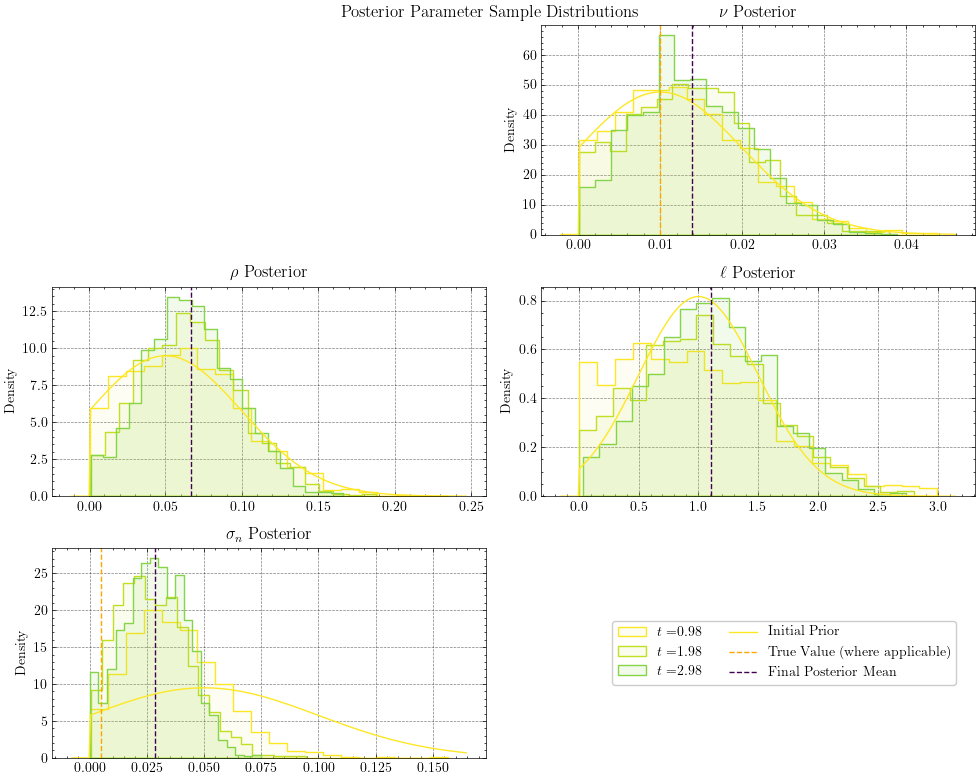

In [ ]:
group_labels = [r"$t= $"+str(round(temporal_measurement_coordinates[i],3)) for i in range(len(temporal_measurement_coordinates))]

# Plotting histograms
plt.figure(figsize=(10, 8))

bins_num = 20

# plt.subplot(3, 2, 1)
# group = 1
# alpha_val = 0.05
# col_index = 0
# for trace in traces:
#     if group == 1:
#         ax = sns.histplot(trace.posterior['alpha'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=alpha_val, color=color_list[col_index])
#     else:
#         sns.histplot(trace.posterior['alpha'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=alpha_val, color=color_list[col_index])
#     alpha_val += 0.025
#     col_index += 1
#     group += 1
# x_left, x_right = ax.get_xlim()
# bottom_axis = np.linspace(x_left, x_right, 300)
# a, b = (alpha_params[0] - alpha_params[2]) / alpha_params[3], (alpha_params[1] - alpha_params[2]) / alpha_params[3]
# truncated_normal = truncnorm(a, b, loc=alpha_params[2], scale=alpha_params[3])
# plt.plot(bottom_axis, truncated_normal.pdf(bottom_axis), label='Initial Prior', color=color_list[0])
# plt.axvline(true_alpha, color='orange', label='True Value', linestyle='--')
# plt.axvline(alpha, label='Final Posterior Mean', linestyle='--', color=color_list[-1])
# #plt.legend()
# ax.set_title(r'$\alpha$ Posterior')

plt.subplot(3, 2, 2)
group = 1
alpha_val = 0.05
col_index = 0
for trace in traces:
    if group == 1:
        ax = sns.histplot(trace.posterior['nu'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=alpha_val, color=color_list[col_index])
    else:
        sns.histplot(trace.posterior['nu'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=alpha_val, color=color_list[col_index])
    group += 1
    alpha_val += 0.025
    col_index += 1
x_left, x_right = ax.get_xlim()
bottom_axis = np.linspace(x_left, x_right, 300)
a, b = (nu_params[0] - nu_params[2]) / nu_params[3], (nu_params[1] - nu_params[2]) / nu_params[3]
truncated_normal = truncnorm(a, b, loc=nu_params[2], scale=nu_params[3])
plt.plot(bottom_axis, truncated_normal.pdf(bottom_axis), label='Initial Prior', color=color_list[0])
plt.axvline(true_nu, color='orange', label='True Value', linestyle='--')
plt.axvline(nu, label='Final Posterior Mean', linestyle='--', color=color_list[-1])
#plt.legend()
ax.set_title(r'$\nu$ Posterior')

plt.subplot(3, 2, 3)
group = 1
alpha_val = 0.05
col_index = 0
for trace in traces:
    if group == 1:
        ax = sns.histplot(trace.posterior['rho'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=alpha_val, color=color_list[col_index])
    else:
        sns.histplot(trace.posterior['rho'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=alpha_val, color=color_list[col_index])
    group += 1
    alpha_val += 0.025
    col_index += 1
x_left, x_right = ax.get_xlim()
bottom_axis = np.linspace(x_left, x_right, 300)
a, b = (rho_params[0] - rho_params[2]) / rho_params[3], (rho_params[1] - rho_params[2]) / rho_params[3]
truncated_normal = truncnorm(a, b, loc=rho_params[2], scale=rho_params[3])
plt.plot(bottom_axis, truncated_normal.pdf(bottom_axis), label='Initial Prior', color=color_list[0])
plt.axvline(rho, label='Final Posterior Mean', linestyle='--', color=color_list[-1])
#plt.legend()
ax.set_title(r'$\rho$ Posterior')

plt.subplot(3, 2, 4)
group = 1
alpha_val = 0.05
col_index = 0
for trace in traces:
    if group == 1:
        ax = sns.histplot(trace.posterior['ell'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=alpha_val, color=color_list[col_index])
    else:
        sns.histplot(trace.posterior['ell'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=alpha_val, color=color_list[col_index])
    group += 1
    alpha_val += 0.025
    col_index += 1
x_left, x_right = ax.get_xlim()
bottom_axis = np.linspace(x_left, x_right, 300)
a, b = (ell_params[0] - ell_params[2]) / ell_params[3], (ell_params[1] - ell_params[2]) / ell_params[3]
truncated_normal = truncnorm(a, b, loc=ell_params[2], scale=ell_params[3])
plt.plot(bottom_axis, truncated_normal.pdf(bottom_axis), label='Initial Prior', color=color_list[0])
plt.axvline(ell, label='Final Posterior Mean', linestyle='--', color=color_list[-1])
#plt.legend()
ax.set_title(r'$\ell$ Posterior')

plt.subplot(3, 2, 5)
group = 1
alpha_val = 0.05
col_index = 0
for trace in traces:
    if group == 1:
        ax = sns.histplot(trace.posterior['sigma_n'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=alpha_val, color=color_list[col_index])
    else:
        sns.histplot(trace.posterior['sigma_n'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=alpha_val, color=color_list[col_index])
    group += 1
    alpha_val += 0.025
    col_index += 1
x_left, x_right = ax.get_xlim()
bottom_axis = np.linspace(x_left, x_right, 300)
a, b = (sigma_n_params[0] - sigma_n_params[2]) / sigma_n_params[3], (sigma_n_params[1] - sigma_n_params[2]) / sigma_n_params[3]
truncated_normal = truncnorm(a, b, loc=sigma_n_params[2], scale=sigma_n_params[3])
plt.plot(bottom_axis, truncated_normal.pdf(bottom_axis), label='Initial Prior', color=color_list[0])
plt.axvline(0.005, color='orange', label='True Value (where applicable)', linestyle='--')
plt.axvline(sigma_n, label='Final Posterior Mean', linestyle='--', color=color_list[-1])
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width * 0.52, pos.height])
ax.legend(loc='center right', bbox_to_anchor=(2.1, 0.5),fancybox=True,ncols=2)
ax.set_title(r'$\sigma_n$ Posterior')

plt.tight_layout()
plt.suptitle('Posterior Parameter Sample Distributions')
plt.show()


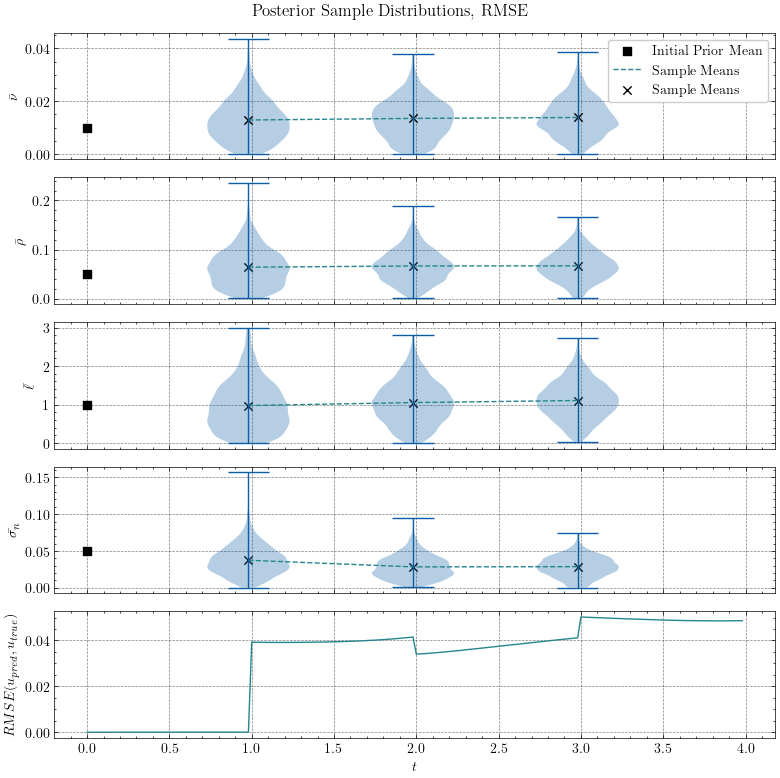

In [ ]:
#nu_estimates = [np.mean(traces[i].posterior['nu'].data.flatten()) for i in range(len(traces))]
# rho_estimates = [np.mean(traces[i].posterior['rho'].data.flatten()) for i in range(len(traces))]
# ell_estimates = [np.mean(traces[i].posterior['ell'].data.flatten()) for i in range(len(traces))]
# sigma_n_estimates = [np.mean(traces[i].posterior['sigma_n'].data.flatten()) for i in range(len(traces))]

nu_estimates = [traces[i].posterior['nu'].data.flatten() for i in range(len(traces))]
rho_estimates = [traces[i].posterior['rho'].data.flatten() for i in range(len(traces))]
ell_estimates = [traces[i].posterior['ell'].data.flatten() for i in range(len(traces))]
sigma_n_estimates = [traces[i].posterior['sigma_n'].data.flatten() for i in range(len(traces))]\

rms = np.sqrt(np.mean((u_s - u_strue)**2, axis=1))
plot_time_coords = temporal_measurement_coordinates

fig, axs = plt.subplots(5, 1, figsize=(8, 8), sharex=True)

axs[0].scatter(0, nu_params[2], marker='s', color='black', label='Initial Prior Mean')
axs[0].plot(plot_time_coords, [np.mean(trace_set) for trace_set in nu_estimates], label='Sample Means', color=color_list[6], linestyle='dashed')
axs[0].violinplot(dataset=nu_estimates, positions=plot_time_coords)
axs[0].scatter(plot_time_coords, [np.mean(trace_set) for trace_set in nu_estimates], marker='x', color='black', label='Sample Means')
#axs[1].set_ylim((beta_params[0],beta_params[1]))
axs[0].legend()
axs[0].set_ylabel(r'$\bar{\nu}$')

axs[1].scatter(0, rho_params[2], marker='s', color='black', label='Initial Prior Mean')
axs[1].plot(plot_time_coords, [np.mean(trace_set) for trace_set in rho_estimates], label='Rho Estimates', color=color_list[6], linestyle='dashed')
axs[1].scatter(plot_time_coords, [np.mean(trace_set) for trace_set in rho_estimates], marker='x', color='black')
axs[1].violinplot(dataset=rho_estimates, positions=plot_time_coords)
axs[1].set_ylabel(r'$\bar{\rho}$')

axs[2].scatter(0, ell_params[2], marker='s', color='black', label='Initial Prior Mean')
axs[2].plot(plot_time_coords,[np.mean(trace_set) for trace_set in ell_estimates], label='Ell Estimates', color=color_list[6], linestyle='dashed')
axs[2].scatter(plot_time_coords, [np.mean(trace_set) for trace_set in ell_estimates], marker='x', color='black')
axs[2].violinplot(dataset=ell_estimates, positions=plot_time_coords)
axs[2].set_ylabel(r'$\bar{\ell}$')

axs[3].scatter(0, sigma_n_params[2], marker='s', color='black', label='Initial Prior Mean')
axs[3].plot(plot_time_coords, [np.mean(trace_set) for trace_set in sigma_n_estimates], label='Sigma_n Estimates', color=color_list[6], linestyle='dashed')
axs[3].scatter(plot_time_coords, [np.mean(trace_set) for trace_set in sigma_n_estimates], marker='x', color='black')
axs[3].violinplot(dataset=sigma_n_estimates, positions=plot_time_coords)
axs[3].set_ylabel(r'$\bar{\sigma_n}$')

axs[4].plot(time_range, rms, label='RMS Error', color=color_list[6])
axs[4].set_ylabel(r'$RMSE(u_{pred}, u_{true})$')
axs[4].set_xlabel(r'$t$')

fig.suptitle('Posterior Sample Distributions, RMSE')
fig.tight_layout()
# Adjust layout
#plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

In [36]:
nu_estimates

[array([0.00748265, 0.00889977, 0.00733136, ..., 0.13496777, 0.13205193,
        0.15764852]),
 array([0.091993  , 0.08508059, 0.12062676, ..., 0.13999293, 0.12321211,
        0.176017  ]),
 array([0.18964217, 0.13969476, 0.15387544, ..., 0.03265435, 0.0327264 ,
        0.31947696])]